# Profiling skforecast

This document shows the profiling of the main classes, methods and functions available in skforecast. Understanding the bottlenecks will help to:

+ Use it more efficiently
+ Improve the code for future releases

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
import psutil

import sklearn
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster

%load_ext pyinstrument

In [2]:
# Versions
# ==============================================================================
print(f"Python version      : {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version  : {skforecast.__version__}")
print(f"pandas version      : {pd.__version__}")
print(f"numpy version       : {np.__version__}")
print(f"psutil version      : {psutil.__version__}")
print("")

# System information
# ==============================================================================
print(f"Machine type: {platform.machine()}")
print(f"Processor type: {platform.processor()}")
print(f"Platform type: {platform.platform()}")
print(f"Operating system: {platform.system()}")
print(f"Operating system release: {platform.release()}")
print(f"Operating system version: {platform.version()}")
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version      : 3.12.11
scikit-learn version: 1.6.1
skforecast version  : 0.17.0
pandas version      : 2.3.1
numpy version       : 2.1.3
psutil version      : 7.0.0

Machine type: AMD64
Processor type: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
Platform type: Windows-11-10.0.26100-SP0
Operating system: Windows
Operating system release: 11
Operating system version: 10.0.26100
Number of physical cores: 8
Number of logical cores: 16


A time series of length 1000 with random values is created.

In [3]:
# Data
# ==============================================================================
np.random.seed(123)
n = 1_000
data = pd.Series(data = np.random.normal(size=n))

## Dummy regressor

To isolate the training process of the regressor from the other parts of the code, a dummy regressor class is created. This dummy regressor has a fit method that does nothing, and a predict method that returns a constant value.

In [4]:
class DummyRegressor(LinearRegression):
    """
    Dummy regressor with dummy fit and predict methods.
    """
    
    def fit(self, X, y):
        pass

    def predict(self, y):
        predictions = np.ones(shape = len(y))
        return predictions

## Profiling fit

_     ._   __/__   _ _  _  _ _/_   Recorded: 16:23:40  Samples:  5
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.006     CPU time: 0.031
/   _/                      v5.0.3

Cell [5]

0.005 <module>  C:\Users\jaesc2\AppData\Local\Temp\ipykernel_28568\930535467.py:1
`- 0.005 ForecasterRecursive.fit  skforecast\recursive\_forecaster_recursive.py:923
      [18 frames hidden]  skforecast, pandas, <built-in>
         0.001 DataFrame.__init__  pandas\core\generic.py:278
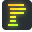

In [5]:
%%pyinstrument

forecaster = ForecasterRecursive(
                 regressor = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

Almost all of the time spent by `fit` is required by the `create_train_X_y` method.

_     ._   __/__   _ _  _  _ _/_   Recorded: 16:23:40  Samples:  110
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.948     CPU time: 0.609
/   _/                      v5.0.3

Cell [6]

1.947 <module>  C:\Users\jaesc2\AppData\Local\Temp\ipykernel_28568\2499331845.py:1
`- 1.947 ForecasterRecursive.fit  skforecast\recursive\_forecaster_recursive.py:923
      [25 frames hidden]  sklearn, joblib, subprocess, threadin...
         1.774 lock.acquire  <built-in>
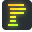

In [6]:
%%pyinstrument

forecaster = ForecasterRecursive(
                 regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

When training a forecaster with a real machine learning regressor, the time spent by `create_train_X_y` is negligible compared to the time needed by the `fit` method of the regressor. Therefore, improving the speed of `create_train_X_y` will not have much impact.

## Profiling create_train_X_y

Understand how the `create_train_X_y` method is influenced by the length of the series and the number of lags. 

In [7]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results = {}

for lags in n_lags:
    execution_time = []
    forecaster = ForecasterRecursive(
                     regressor = DummyRegressor(),
                     lags      = lags
                 )

    for n in series_length:
        y = pd.Series(data = np.random.normal(size=n))
        tic = time.perf_counter()
        _ = forecaster.create_train_X_y(y=y)
        toc = time.perf_counter()
        execution_time.append(toc - tic)

    results[lags] = execution_time

results = pd.DataFrame(
              data = results,
              index = series_length
          )

results

,5,10,50,100,200
1000,0.000817,0.003778,0.006570,0.027220,0.083118
250750,0.005524,0.008127,0.030577,0.073946,0.120689
500500,0.009436,0.015381,0.070102,0.146196,0.289218
750250,0.013998,0.024984,0.104574,0.335631,0.616191
1000000,0.019030,0.036879,0.181628,0.612827,0.798728


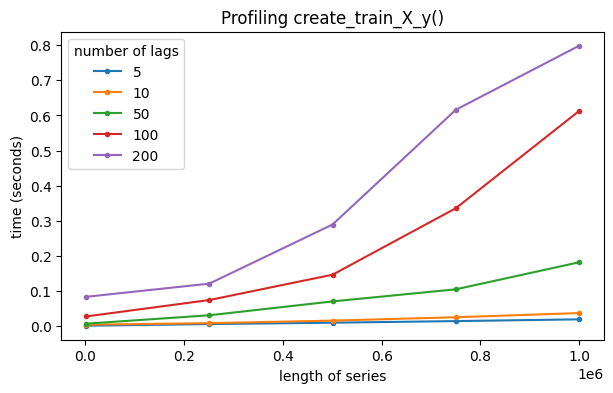

In [8]:
fig, ax = plt.subplots(figsize=(7, 4))
results.plot(ax=ax, marker='.')
ax.set_xlabel('length of series')
ax.set_ylabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title='number of lags');

## Profiling predict

In [9]:
forecaster = ForecasterRecursive(
                 regressor = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 16:23:46  Samples:  24
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.194     CPU time: 0.188
/   _/                      v5.0.3

Cell [10]

0.193 ZMQInteractiveShell.run_ast_nodes  IPython\core\interactiveshell.py:3540
`- 0.191 <module>  C:\Users\jaesc2\AppData\Local\Temp\ipykernel_28568\3639615597.py:1
   |- 0.169 [self]  C:\Users\jaesc2\AppData\Local\Temp\ipykernel_28568\3639615597.py
   `- 0.022 ForecasterRecursive.predict  skforecast\recursive\_forecaster_recursive.py:1457
         [2 frames hidden]  skforecast, <built-in>
            0.019 ForecasterRecursive._recursive_predict  skforecast\recursive\_forecaster_recursive.py:1254
            `- 0.003 DummyRegressor.predict  C:\Users\jaesc2\AppData\Local\Temp\ipykernel_28568\4114816888.py:9
               `- 0.003 ones  numpy\_core\numeric.py:144
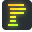

In [10]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

In [11]:
forecaster = ForecasterRecursive(
                 regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 16:23:47  Samples:  1356
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.567     CPU time: 7.688
/   _/                      v5.0.3

Cell [12]

1.565 <module>  C:\Users\jaesc2\AppData\Local\Temp\ipykernel_28568\3639615597.py:1
`- 1.565 ForecasterRecursive.predict  skforecast\recursive\_forecaster_recursive.py:1457
      [34 frames hidden]  skforecast, sklearn, <built-in>, nump...
         0.679 TreePredictor.predict  sklearn\ensemble\_hist_gradient_boosting\predictor.py:46
         `- 0.659 [self]  sklearn\ensemble\_hist_gradient_boosting\predictor.py
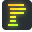

In [12]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

Inside the `predict` method, the `append` action is the most expensive but, similar to what happen with `fit`, it is negligible compared to the time need by the `predict` method of the regressor.